In [1]:
%matplotlib inline
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from itertools import chain
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Read in and preprocess data 

In [2]:
#read all data
xls = pd.ExcelFile('./Compiled_survey.xlsx')
Jan18 = pd.read_excel(xls, 'Jan 2018')
Jan18['month'] = 'Jan 2018'
Dec17 = pd.read_excel(xls, 'Dec 2017')
Dec17['month'] = 'Dec 2017'
Nov17 = pd.read_excel(xls, 'Nov 2017')
Nov17['month'] = 'Nov 2017'
Oct17 = pd.read_excel(xls, 'Oct 2017')
Oct17['month'] = 'Oct 2017'
Sept17 = pd.read_excel(xls, 'Sept 2017')
Sept17['month'] = 'Sept 2017'
Aug17 = pd.read_excel(xls, 'August 2017')
Aug17['month'] = 'Aug 2017'
Jul17 = pd.read_excel(xls, 'July 2017')
Jul17['month'] = 'Jul 2017'
Jun17 = pd.read_excel(xls, 'June 2017')
Jun17['month'] = 'Jun 2017'
May17 = pd.read_excel(xls, 'May 2017')
May17['month'] = 'May 2017'
Apr17 = pd.read_excel(xls, 'April 2017')
Apr17['month'] = 'April 2017'
Mar17 = pd.read_excel(xls, 'Mar 2017')
Mar17['month'] = 'March 2017'
Feb17 = pd.read_excel(xls, 'Feb 2017')
Feb17['month'] = 'Feb 2017'
Jan17 = pd.read_excel(xls, 'Jan 2017')
Jan17['month'] = 'Jan 2017'

In [3]:
#combine data frames into one
#data = pd.concat([Jan18, Dec17, Nov17, Oct17, Sept17, Aug17, Jul17,Jun17, May17, Apr17,
#         Mar17, Feb17, Jan17])

data = pd.concat([Jan18, Dec17, Nov17])

In [4]:
#rename columns
data = data.rename(index=str, columns={"Date":"date", "What is the purpose for your visit today?": "purpose",
                                 'Were you able to complete your task today?':"task_completion",
                                 "How would you rate the level of effort you had to put forth to handle your request today?": "effort",
                                 'How did this effort compare to your expectations?':'expectations',
                                 'How likely is it that you would recommend FasTrak to a friend or colleague?':'recommend',
                                 "Additional Feedback (Optional)": "feedback",
                                "month":"month"})

In [5]:
#drop unneeded column 
#data = data.drop('#', 1)

In [6]:
data["month"].value_counts()

Jan 2018    13809
Nov 2017    13237
Dec 2017    11579
Name: month, dtype: int64

In [7]:
data.shape

(38625, 8)

### Filter for only rows with feedback responses

In [8]:
#get only rows with feedback filled out
feedback = data[data.feedback.notnull()]

In [9]:
feedback["month"].value_counts()

Jan 2018    2668
Nov 2017    2551
Dec 2017    2202
Name: month, dtype: int64

In [10]:
feedback["purpose"].value_counts()

Account Update               3457
Register Toll Tag            1477
Account Balance              1079
Pay a Violation               586
Dispute Violation/Invoice     381
Pay an Invoice                353
Name: purpose, dtype: int64

In [11]:
feedback.shape

(7421, 8)

### Filter feedback based on sentiment and type

In [12]:
# compile documents into a list
feedback_list = feedback.feedback.tolist()

# remove numbers from documents
feedback_list = [x for x in feedback_list if type(x) != int]

In [13]:
# sentiment analysis
analyzer = SentimentIntensityAnalyzer()

sentiment_dict = {}
for i in feedback_list:
    sentiment_dict[i] = analyzer.polarity_scores(i)

In [14]:
pos_list = []
for k, v in zip(sentiment_dict.keys(), sentiment_dict.values()):
    if v['pos'] > 0.6:
        pos_list.append(k)
len(pos_list)

372

In [15]:
pos_dict = {}
neg_dict = {}
nuet_dict = {}
compound_dict = {}
for k, v in zip(sentiment_dict.keys(), sentiment_dict.values()):
    pos_dict[k]  = v['pos']
    neg_dict[k]  = v['neg']
    nuet_dict[k]  = v['neu']
    compound_dict[k]  = v['compound']
    
feedback['positive'] = feedback["feedback"].map(pos_dict)
feedback['negative'] = feedback["feedback"].map(neg_dict)
feedback['nuetral'] = feedback["feedback"].map(nuet_dict)
feedback['compound'] = feedback["feedback"].map(compound_dict)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [78]:
#feedback.head(1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a202804d0>]], dtype=object)

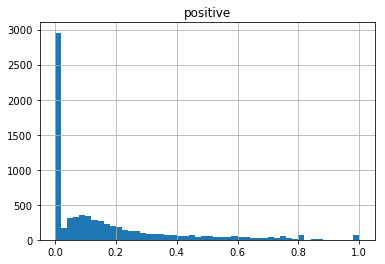

In [17]:
feedback.hist(column='positive', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21f4d890>]], dtype=object)

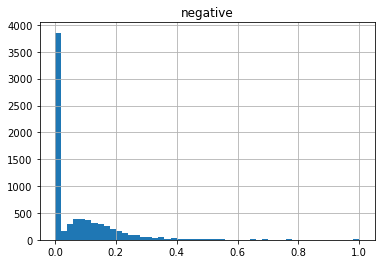

In [18]:
feedback.hist(column='negative', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21f4d3d0>]], dtype=object)

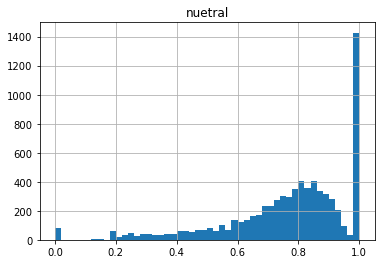

In [19]:
feedback.hist(column='nuetral', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2430d350>]], dtype=object)

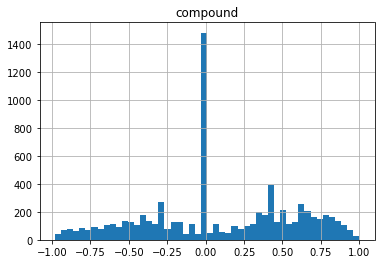

In [20]:
feedback.hist(column='compound', bins=50)

In [21]:
# filter out uniformative feedback (super positive or super negative)
# these are generally short responses that provide no helpful information
feedback2 = feedback[(feedback['positive'] < 0.6) &
        (feedback['negative'] < 0.6)]

In [22]:
feedback2["purpose"].value_counts()

Account Update               3126
Register Toll Tag            1414
Account Balance              1028
Pay a Violation               564
Dispute Violation/Invoice     372
Pay an Invoice                335
Name: purpose, dtype: int64

In [60]:
# divide into purpose categories
feedback_update = feedback2[feedback2["purpose"] == "Account Update"]
feedback_register = feedback2[feedback2["purpose"] == "Register Toll Tag"]
feedback_acctbalance = feedback2[feedback2["purpose"] == "Account Balance"]
feedback_payviolation = feedback2[feedback2["purpose"] == "Pay a Violation"]
feedback_dispute = feedback2[feedback2["purpose"] == "Dispute Violation/Invoice"]
feedback_payinvoice = feedback2[feedback2["purpose"] == "Pay an Invoice"]

In [24]:
# divide into task completion categories
feedback_yes_completion = feedback2[feedback2["task_completion"] == "Yes"]
feedback_no_completion = feedback2[feedback2["task_completion"] == "No"]

In [25]:
# pull out feeback by phrase
feedback_word = feedback2[feedback2['feedback'].str.contains("mobile", na=False)]


In [26]:
feedback_word['purpose'].value_counts()

Account Update               51
Account Balance              19
Register Toll Tag            10
Pay an Invoice                4
Pay a Violation               2
Dispute Violation/Invoice     1
Name: purpose, dtype: int64

In [27]:
feedback_no_completion['purpose'].value_counts()

Account Update               563
Register Toll Tag            255
Dispute Violation/Invoice    238
Account Balance              196
Pay a Violation              166
Pay an Invoice                88
Name: purpose, dtype: int64

In [28]:
# filter out super positive feedback
yes_completion_register = feedback_yes_completion[feedback_yes_completion['purpose'] == 'Register Toll Tag']
no_completion_register = feedback_no_completion[feedback_no_completion['purpose'] == 'Register Toll Tag']

yes_completion_update = feedback_yes_completion[feedback_yes_completion['purpose'] == 'Account Update']
no_completion_update = feedback_no_completion[feedback_no_completion['purpose'] == 'Account Update']

yes_completion_pay = feedback_yes_completion[feedback_yes_completion['purpose'] == 'Pay a Violation']
no_completion_pay = feedback_no_completion[feedback_no_completion['purpose'] == 'Pay a Violation']

In [29]:
feedback2.shape

(6927, 12)

In [30]:
feedback_yes_completion.shape

(5349, 12)

## LDA

In [61]:
def create_docset(df):
    # compile documents into a list
    doc_set = df.feedback.tolist()

    #remove numbers from documents
    doc_set = [x for x in doc_set if type(x) != int]
    
    print len(doc_set)
    
    return doc_set

In [62]:
def topic_modeling(doc_set = doc_set, num_topics = 6):
    
    # remove words only appearing once in whole list
    # https://stackoverflow.com/questions/21100903/improve-performance-remove-all-strings-in-a-big-list-appearing-only-once
    c = Counter(word for x in doc_set for word in x.split())
    doc_set = [' '.join(y for y in x.split() if c[y] > 1) for x in doc_set]
    
    #create tokenizer
    tokenizer = RegexpTokenizer(r'\w+')

    # create English stop words list
    en_stop = get_stop_words('en')
    
    #add custom words to stop words list
    en_stop.extend(["fastrak", "fastrack", "fas", "trak", "track", "t"])

    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    
    # list for tokenized documents in loop
    texts = []

    # loop through document list
    for i in doc_set:
        
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]

        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        
        # add tokens to list
        texts.append(stemmed_tokens) # texts is a list of list of tokens for each doc (feedback response)
    
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)
    
    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # generate LDA model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word = dictionary, 
                                           passes=20, minimum_probability=0)
    return ldamodel, corpus

In [63]:
doc_set = create_docset(df = feedback_register)

1414


In [64]:
ldamodel, corpus = topic_modeling(doc_set)

In [79]:
for top in ldamodel.print_topics(num_words=4):
    #print(top)

IndentationError: expected an indented block (<ipython-input-79-dbe6f1fe8fcb>, line 2)

## Interpretting results

https://stackoverflow.com/questions/20984841/topic-distribution-how-do-we-see-which-document-belong-to-which-topic-after-doi

feedback_register , 6 topics

In [74]:
def get_results(ldamodel = ldamodel, corpus = corpus, num_topics = 6):
    # Assigns the topics to the documents in corpus
    lda_corpus = ldamodel[corpus]
    # Find the threshold, let's set the threshold to be 1/#clusters,
    # To prove that the threshold is sane, we average the sum of all probabilities:
    scores = list(chain(*[[score for topic_id,score in topic] \
                          for topic in [doc for doc in lda_corpus]]))
    threshold = sum(scores)/len(scores)
    print threshold
    
    for x in range(num_topics):
        print "   "
        print "   "
        print "Results for Topic {}".format(x)
        print ldamodel.print_topics(num_words=4)[x]
        print "   "
        topic = [(i[x][1],j) for i,j in zip(lda_corpus,doc_set) if i[x][1] > threshold]
        print sorted(topic, key=lambda tup: tup[0], reverse = True)[:10]

In [76]:
#get_results(ldamodel = ldamodel, corpus = corpus, num_topics = 6)

In [77]:
ldamodel, corpus = topic_modeling(cluster3)
for top in ldamodel.print_topics(num_words=6):
    #print(top)

IndentationError: expected an indented block (<ipython-input-77-fb7518717550>, line 3)